In [1]:
from functions import intodf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from itertools import product

K Nearest Neighbors
1. First testing parameters using CV with **original data (8columns)**

Data cleaning: defining df1,2,3 for image1,2,3

In [2]:
df3 = intodf('O013257.npz') #image3 - test
df2 = intodf('O013490.npz') #image2 - train
df1 = intodf('O012791.npz') #image1 - train

# Drop label=0 since they are of no use.
df1 = df1[df1['label'] != 0]
df2 = df2[df2['label'] != 0]
df3 = df3[df3['label'] != 0]

In [3]:
# Define features and labels for each
X_df1 = df1.drop(columns=["X", "Y", "label"])
y_df1 = df1["label"]
X_df2 = df2.drop(columns=["X", "Y", "label"])
y_df2 = df2["label"]
X_test = df3.drop(columns=["X", "Y", "label"])
y_test = df3["label"]

# Full training set for final retraining
df_train = pd.concat([df1, df2])
X_train_full = df_train.drop(columns=["X", "Y", "label"])
y_train_full = df_train["label"]

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from itertools import product
import numpy as np

# Hyperparameter grid
param_grid = {
    'n_neighbors': list(range(3, 10)),
    'weights': ['uniform', 'distance']
}

###### 2-Fold CV setup #######
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

## Grid search for the combinations of hyperparameters
scaler = StandardScaler()

for n_neighbors, weights in product(param_grid['n_neighbors'], param_grid['weights']):
    val_errors = []
    print(f"Testing: n_neighbors={n_neighbors}, weights={weights}")
    
    for X_train, y_train, X_valid, y_valid in folds:
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_valid_scaled)
        val_error = 1 - accuracy_score(y_valid, y_pred)
        val_errors.append(val_error)

    avg_val_error = np.mean(val_errors)
    print(f"Average Validation Error: {avg_val_error:.4f}")

    if avg_val_error < best_avg_val_error:
        best_avg_val_error = avg_val_error
        best_params = {'n_neighbors': n_neighbors, 'weights': weights}

print(f"\nBest Parameters: n_neighbors={best_params['n_neighbors']}, weights={best_params['weights']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters!!!!
print("\nRetraining with best parameters...")
final_model_1 = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])
final_model_1.fit(X_train_full, y_train_full)

# Test on df3, the third picture!!!
y_pred_1 = final_model_1.predict(X_test)
y_pred_binary_1 = np.where(y_pred_1 > 0.5, 1, -1)
y_pred_proba_1 = final_model_1.predict_proba(X_test)[:, 1]
test_accuracy_model_1 = accuracy_score(y_test, y_pred_binary_1)
test_error_1 = 1 - test_accuracy_model_1
print(f"Test Error with only original features on df3: {test_error_1:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy_model_1:.4f}")

Testing: n_neighbors=3, weights=uniform
Average Validation Error: 0.3692
Testing: n_neighbors=3, weights=distance
Average Validation Error: 0.3692
Testing: n_neighbors=4, weights=uniform
Average Validation Error: 0.3546
Testing: n_neighbors=4, weights=distance
Average Validation Error: 0.3709
Testing: n_neighbors=5, weights=uniform
Average Validation Error: 0.3568
Testing: n_neighbors=5, weights=distance
Average Validation Error: 0.3567
Testing: n_neighbors=6, weights=uniform
Average Validation Error: 0.3458
Testing: n_neighbors=6, weights=distance
Average Validation Error: 0.3598
Testing: n_neighbors=7, weights=uniform
Average Validation Error: 0.3487
Testing: n_neighbors=7, weights=distance
Average Validation Error: 0.3490
Testing: n_neighbors=8, weights=uniform
Average Validation Error: 0.3399
Testing: n_neighbors=8, weights=distance
Average Validation Error: 0.3510
Testing: n_neighbors=9, weights=uniform
Average Validation Error: 0.3429
Testing: n_neighbors=9, weights=distance
Aver

2. Now testing KNN on df with **additional 32 ae_features**

In [5]:
# Load the three csv files from data_labeled
image_1 = pd.read_csv('../data/data_labeled/image1_ae.csv') 
image_2 = pd.read_csv('../data/data_labeled/image2_ae.csv')
image_3 = pd.read_csv('../data/data_labeled/image3_ae.csv')

In [6]:
#Rename the first two columns!!! convert from x,y to X,Y
image_1 = image_1.rename(columns={'y': 'Y', 'x': 'X'})
image_2 = image_2.rename(columns={'y': 'Y', 'x': 'X'})
image_3 = image_3.rename(columns={'y': 'Y', 'x': 'X'})

# Merge original feature with 32 additional features on X and Y coordinates
df1_new = pd.merge(df1, image_1, on=['X', 'Y'], how='inner')
df2_new = pd.merge(df2, image_2, on=['X', 'Y'], how='inner')
df3_new = pd.merge(df3, image_3, on=['X', 'Y'], how='inner')
#now each df has 43 columns. (8 original + 32 new ae features) 

In [7]:
# Prepare features and labels
X_df1 = df1_new.drop(columns=['X', 'Y', 'label'])  # 40 features
y_df1 = df1_new['label']
X_df2 = df2_new.drop(columns=['X', 'Y', 'label'])
y_df2 = df2_new['label']
X_test = df3_new.drop(columns=['X', 'Y', 'label'])
y_test = df3_new['label']

df_train = pd.concat([df1_new, df2_new])
X_train_full = df_train.drop(columns=['X', 'Y', 'label'])
y_train_full = df_train['label']

In [8]:
# Hyperparameter grid (adjusted for more features)
param_grid = {
    'n_neighbors': list(range(3, 10)),
    'weights': ['uniform', 'distance']
}

# 2-Fold CV setup
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

## Grid search for the combinations of hyperparameters
scaler = StandardScaler()

for n_neighbors, weights in product(param_grid['n_neighbors'], param_grid['weights']):
    val_errors = []
    print(f"Testing: n_neighbors={n_neighbors}, weights={weights}")
    
    for X_train, y_train, X_valid, y_valid in folds:
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_valid_scaled)
        val_error = 1 - accuracy_score(y_valid, y_pred)
        val_errors.append(val_error)

    avg_val_error = np.mean(val_errors)
    print(f"Average Validation Error: {avg_val_error:.4f}")

    if avg_val_error < best_avg_val_error:
        best_avg_val_error = avg_val_error
        best_params = {'n_neighbors': n_neighbors, 'weights': weights}

# Final output
print(f"\nBest Parameters: n_neighbors={best_params['n_neighbors']}, weights={best_params['weights']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters!!!!
print("\nRetraining with best parameters...")
final_model_2 = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])
final_model_2.fit(X_train_full, y_train_full)

# Test on df3, the third picture!!!
y_pred_2 = final_model_2.predict(X_test)
y_pred_binary_2 = np.where(y_pred_2 > 0.5, 1, -1)
y_pred_proba_2 = final_model_2.predict_proba(X_test)[:, 1]
test_accuracy_model_2 = accuracy_score(y_test, y_pred_binary_2)
test_error_2 = 1 - test_accuracy_model_2
print(f"Test Error with only original features on df3: {test_error_2:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy_model_2:.4f}")

Testing: n_neighbors=3, weights=uniform
Average Validation Error: 0.2763
Testing: n_neighbors=3, weights=distance
Average Validation Error: 0.2763
Testing: n_neighbors=4, weights=uniform
Average Validation Error: 0.2783
Testing: n_neighbors=4, weights=distance
Average Validation Error: 0.2759
Testing: n_neighbors=5, weights=uniform
Average Validation Error: 0.2768
Testing: n_neighbors=5, weights=distance
Average Validation Error: 0.2768
Testing: n_neighbors=6, weights=uniform
Average Validation Error: 0.2785
Testing: n_neighbors=6, weights=distance
Average Validation Error: 0.2764
Testing: n_neighbors=7, weights=uniform
Average Validation Error: 0.2771
Testing: n_neighbors=7, weights=distance
Average Validation Error: 0.2771
Testing: n_neighbors=8, weights=uniform
Average Validation Error: 0.2794
Testing: n_neighbors=8, weights=distance
Average Validation Error: 0.2773
Testing: n_neighbors=9, weights=uniform
Average Validation Error: 0.2785
Testing: n_neighbors=9, weights=distance
Aver

Seems that the model with all the features (original + ae_features) seems better. 
Now we will draw confusion matrices for both models, to compare side by side.

Confusion Matrix

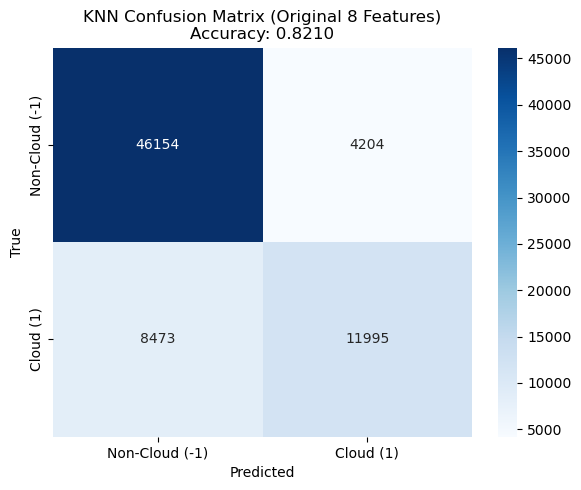

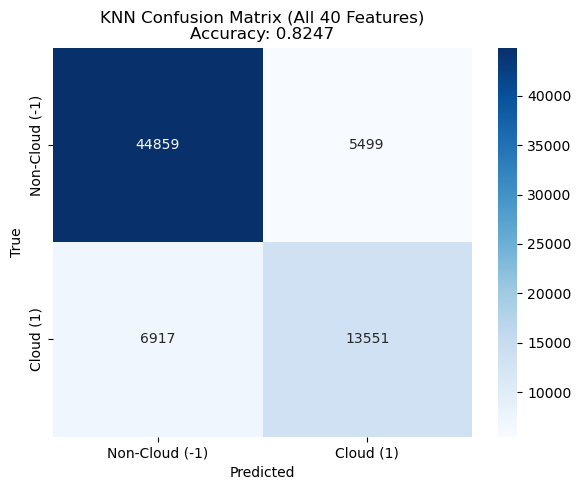

In [10]:
# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_binary_1)
cm_2 = confusion_matrix(y_test, y_pred_binary_2)

# Compute accuracies (for reference)
acc_1 = accuracy_score(y_test, y_pred_binary_1)
acc_2 = accuracy_score(y_test, y_pred_binary_2)

# === Plot 1: Confusion Matrix for Original Features ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
plt.title(f'KNN Confusion Matrix (Original 8 Features)\nAccuracy: {acc_1:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# === Plot 2: Confusion Matrix for All Features ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
plt.title(f'KNN Confusion Matrix (All 40 Features)\nAccuracy: {acc_2:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [11]:
# 1. Precision, Recall, F1 Score
# Compute for both models (for the positive class: Cloud, label=1)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(y_test, y_pred_binary_1, average='binary', pos_label=1)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(y_test, y_pred_binary_2, average='binary', pos_label=1)

print("Model 1 (final_model_1):")
print(f"Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_1:.4f}")
print("Model 2 (final_model_2):")
print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")

Model 1 (final_model_1):
Precision: 0.7405, Recall: 0.5860, F1 Score: 0.6543
Model 2 (final_model_2):
Precision: 0.7113, Recall: 0.6621, F1 Score: 0.6858


For the knn results, the model accuracy after adding the 32 features generated by the autoencoder also showed an increase, by approximately 0.37%. Both recall and the F1 score improved, although precision showed a decrease. On a prediction dataset with an imbalance of categories (non-clouds in the majority and clouds in the minority), we still believe that the 32 generated features increase the prediction power slightly.

In [12]:
# 2. Approximate AIC
# For KNN, we approximate AIC using log-loss (binary cross-entropy)
# AIC = 2k - 2*ln(L), where ln(L) is approximated via log-loss
# k = number of parameters (approximated as number of features + 1 for intercept-like term)

# Number of features
k_1 = 8   # final_model_1 (best with 8 neighbors)
k_2 = 4  # final_model_2 (best with 4 neighbors)

# Compute log-loss (requires probability predictions)
y_test_adjusted = (y_test + 1) // 2
logloss_1 = log_loss(y_test_adjusted, y_pred_proba_1)  
logloss_2 = log_loss(y_test_adjusted, y_pred_proba_2)

# Approximate AIC: 2k + n * logloss (since logloss = -ln(L)/n, so -ln(L) = n * logloss)
n = len(y_test)
aic_1 = 2 * k_1 + n * logloss_1
aic_2 = 2 * k_2 + n * logloss_2

print("\nApproximate AIC:")
print(f"Model 1 (final_model_1): {aic_1:.2f}")
print(f"Model 2 (final_model_2): {aic_2:.2f}")


Approximate AIC:
Model 1 (final_model_1): 209435.30
Model 2 (final_model_2): 268500.46


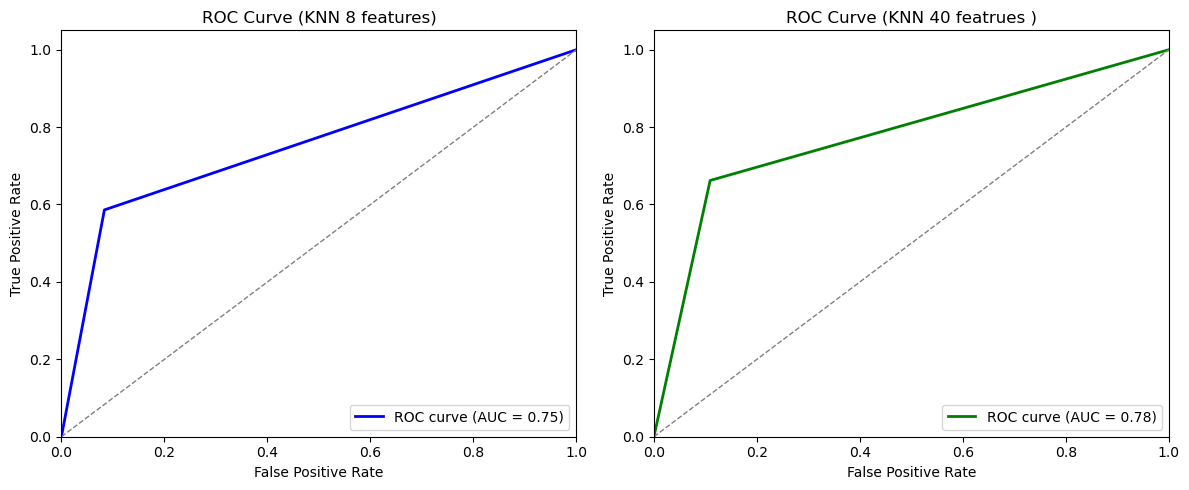

In [13]:
# 3. ROC Curve
# Compute ROC curves and AUC
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_1, pos_label=1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_2, pos_label=1)
roc_auc_2 = auc(fpr_2, tpr_2)

# Plot ROC curves side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ax1.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_1:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (KNN 8 features)')
ax1.legend(loc="lower right")

# Model 2
ax2.plot(fpr_2, tpr_2, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_2:.2f})')
ax2.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (KNN 40 featrues )')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [13]:
df3_new['label'].value_counts()

label
-1.0    50358
 1.0    20468
Name: count, dtype: int64

Draw plots for post-hoc EDA!!!!

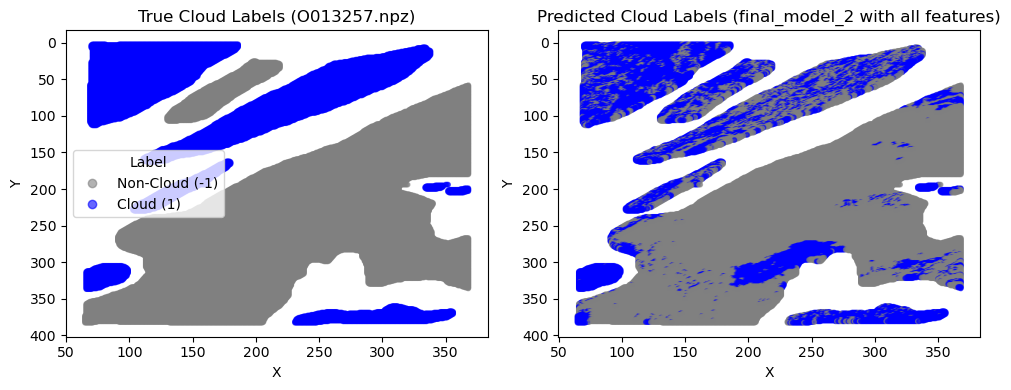

In [14]:
#plots for test picture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming df3_new and y_pred_binary_2 are already defined
# Create a dataframe with X, Y, true labels, and predicted labels
plot_df = pd.DataFrame({
    'X': df3_new['X'],
    'Y': df3_new['Y'],
    'True_Label': df3_new['label'],
    'Predicted_Label': y_pred_binary_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013257.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

Now we check the prediction plots and the actual plots for the pictures used in train. 

In [15]:
#plot for two train pictures

#first fit the y_predict_binary_2 for df1 and df2
y_pred_2_1 = final_model_2.predict(X_df1) 
y_pred_2_2 = final_model_2.predict(X_df2) 
y_pred_binary_2_1 = np.where(y_pred_2_1 > 0.5, 1, -1) #get predicted binary values for df1
y_pred_binary_2_2 = np.where(y_pred_2_2 > 0.5, 1, -1) #get predicted binary values for df2


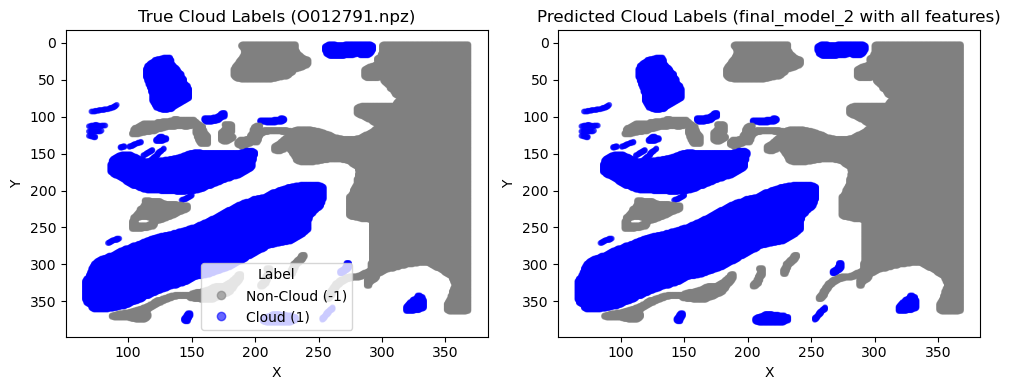

In [16]:
plot_df = pd.DataFrame({
    'X': df1_new['X'],
    'Y': df1_new['Y'],
    'True_Label': df1_new['label'],
    'Predicted_Label': y_pred_binary_2_1
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O012791.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

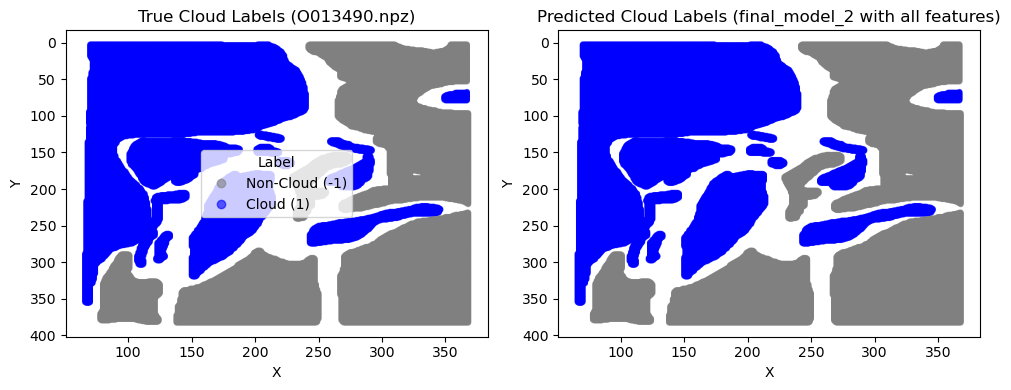

In [17]:
plot_df = pd.DataFrame({
    'X': df2_new['X'],
    'Y': df2_new['Y'],
    'True_Label': df2_new['label'],
    'Predicted_Label': y_pred_binary_2_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013490.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

We can clearly see that the prediction for the train pictures are nearly perfect. 
